# Entrenamiento arquitectura recurrente con espectrograma
-----
En este notebook se realiza el entrenamiento de la arquitectura Convolucional sin aplicar normalización, para el desarrollo del trabajo de grado titulado: "Clasificación de patologías cardiovasculares con máquinas de aprendizaje profundo a partir de señales ECG".


# Importando Librerías

In [1]:
import optuna
import plotly
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, regularizers, initializers, callbacks
import random as python_random
from numpy.random import seed
np.random.seed(123)
tf.random.set_seed(11)
python_random.seed(123)
os.environ['PYTHONHASHSEED'] = '0'
from keras import backend as K
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import tensorflow
import gc
from sklearn.metrics import confusion_matrix
import itertools
from keras.callbacks import ModelCheckpoint
import json


# Definiendo funciones

In [2]:
TAMANIO=60

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def plot_confusion_matrix(cm, classes,ruta,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2. 
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.gcf().set_size_inches(6,5)
    plt.savefig(ruta,dpi=300)
    plt.show()
def codificacion(tamano,unico=True,numero=0):
    #Vector de unos
    if unico==True:
        Y_train=np.ones(tamano)*numero
    else:
        for i in range(0,5):
            if i==0:
                Y_train=np.ones(tamano)*i
            else:
                vectorUnos=np.ones(tamano)
                Y_train=np.insert(Y_train,len(Y_train),vectorUnos*i,axis=0)
    return Y_train

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it does something you should see a number as output

    # use the same config as you used to create the session
    config = tensorflow.compat.v1.ConfigProto()
    tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 1)
    tf.compat.v1.GPUOptions(visible_device_list = "0")
    set_session(tf.compat.v1.Session(config=config))

def load_data_test_cnn():
    # load your data using this function
    path='C:\\Users\jdani\\Documents\\TrabajoDeGrado\\BDConEspectrograma\\MatricesNumpyGuardadas_NS\\ECG_'
    ECG_Normal_Test=np.load(path+'Normal\\ECG_Normal_test.npy')
    ECG_SBR_Test=np.load(path+'SBR\\ECG_SBR_Original.npy')
    ECG_SBR_Test=ECG_SBR_Test[300:360,:,:,:]
    ECG_AFIB_Test=np.load(path+'AFIB\\ECG_AFIB_test.npy')
    ECG_STD_Test=np.load(path+'STD\\ECG_STD_test.npy')
    ECG_STE_Test=np.load(path+'STE\\ECG_STE_test.npy')

    filas_seleccionadas = np.random.choice(len(ECG_Normal_Test), size=TAMANIO, replace=False)
    ECG_Normal_Test = ECG_Normal_Test[filas_seleccionadas]
    filas_seleccionadas = np.random.choice(len(ECG_AFIB_Test), size=TAMANIO, replace=False)
    ECG_AFIB_Test = ECG_AFIB_Test[filas_seleccionadas]
    filas_seleccionadas = np.random.choice(len(ECG_STD_Test), size=TAMANIO, replace=False)
    ECG_STD_Test = ECG_STD_Test[filas_seleccionadas]
    filas_seleccionadas = np.random.choice(len(ECG_STE_Test), size=TAMANIO, replace=False)
    ECG_STE_Test = ECG_STE_Test[filas_seleccionadas]
    

    y_Normal_Test=codificacion(len(ECG_Normal_Test),True,0)
    y_SBR_Test=codificacion(len(ECG_SBR_Test),True,1)
    y_AFIB_Test=codificacion(len(ECG_AFIB_Test),True,2)
    y_STD_Test=codificacion(len(ECG_STD_Test),True,3)
    y_STE_Test=codificacion(len(ECG_STE_Test),True,4)

    #Generando X_train

    X_test=np.concatenate((ECG_Normal_Test,
                                ECG_SBR_Test,
                                ECG_AFIB_Test,
                                ECG_STE_Test,
                                ECG_STD_Test))

    Y_test=np.insert(y_Normal_Test,len(y_Normal_Test),y_SBR_Test,axis=0)
    Y_test=np.insert(Y_test,len(Y_test),y_AFIB_Test,axis=0)
    Y_test=np.insert(Y_test,len(Y_test),y_STD_Test,axis=0)
    Y_test=np.insert(Y_test,len(Y_test),y_STE_Test,axis=0)    

    print('Tamaño datos test: '+ str(X_test.shape))
    print('Tamaño etiquetas de test: '+str(Y_test.shape))   
    return X_test,Y_test
def load_data_cnn():
    path='C:\\Users\jdani\\Documents\\TrabajoDeGrado\\BDConEspectrograma\\MatricesNumpyGuardadas_NS\\ECG_'
    #importando patologias
    ECG_Normal_Original=np.load(path+'Normal\\ECG_Normal_Original.npy')
    ECG_SBR_Original=np.load(path+'SBR\\ECG_SBR_Original.npy')
    print(ECG_SBR_Original.shape)
    ECG_AFIB_Original=np.load(path+'AFIB\\ECG_AFIB_Original.npy')
    ECG_STD_Original=np.load(path+'STD\\ECG_STD_Original.npy')
    ECG_STE_Original=np.load(path+'STE\\ECG_STE_Original.npy')
        
    # partiendo base de datos y generando labels
    ECG_Normal_Train=ECG_Normal_Original[:,:,:]
    y_Normal_Train=codificacion(len(ECG_Normal_Train),True,0)
    ECG_SBR_Train=ECG_SBR_Original[:300,:,:]
    y_SBR_Train=codificacion(len(ECG_SBR_Train),True,1)
    ECG_AFIB_Train=ECG_AFIB_Original[:,:,:]
    y_AFIB_Train=codificacion(len(ECG_AFIB_Train),True,2)
    ECG_STD_Train=ECG_STD_Original[:,:,:]
    y_STD_Train=codificacion(len(ECG_STD_Train),True,3)
    ECG_STE_Train=ECG_STE_Original[:,:,:]
    y_STE_Train=codificacion(len(ECG_STE_Train),True,4)

    #Generando Y
    Y_train=np.insert(y_Normal_Train,len(y_Normal_Train),y_SBR_Train,axis=0)
    Y_train=np.insert(Y_train,len(Y_train),y_AFIB_Train,axis=0)
    Y_train=np.insert(Y_train,len(Y_train),y_STD_Train,axis=0)
    Y_train=np.insert(Y_train,len(Y_train),y_STE_Train,axis=0)


    #Generando X_train

    X_train=np.concatenate((ECG_Normal_Train,
                                ECG_SBR_Train,
                                ECG_AFIB_Train,
                                ECG_STE_Train,
                                ECG_STD_Train))
    print('Tamaño datos entrenamiento: '+ str(X_train.shape))
    print('Tamaño etiquetas de entrenamiento: '+str(Y_train.shape))
    
    X_test,Y_test=load_data_test_cnn()
    
    Y_train= keras.utils.to_categorical(Y_train)
    Y_test= keras.utils.to_categorical(Y_test)
    return X_train,Y_train,X_test,Y_test

In [3]:
# X_train,Y_train,X_test,Y_test=load_data_cnn()
# X_train
# X_test

# print()
# print()
# print(X_train.shape)
# print(Y_train.shape)
# print(X_test.shape)
# print(Y_test.shape)

# Creando modelo para optimización con Optuna

In [4]:
#Definiendo constantes
EPOCAS=30
ciclo=0
mejores={}
def modelo_CNN(trial):
    # n_hidden=trial.suggest_int('n_hidden',256,1024)
    drop_path_rate = trial.suggest_float("drop_path_rate", 0.5, 0.8, step=0.1)
    # n_hidden=trial.suggest_int('n_hidden',128,1024)
    n_hidden = trial.suggest_categorical("n_hidden", [128,256])
    # Regularización L2
    input_shape = (4000, 51, 241, 2)
    ModelCNN2D=keras.models.Sequential()
    ModelCNN2D.add(keras.layers.Conv2D(32,(3,3),padding="same",activation="relu",input_shape=input_shape[1:]))
    ModelCNN2D.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    ModelCNN2D.add(keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"))
    ModelCNN2D.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    ModelCNN2D.add(keras.layers.Flatten())
    ModelCNN2D.add(keras.layers.Dense(n_hidden,activation="relu",activity_regularizer=regularizers.L1L2(1e-3)))
    ModelCNN2D.add(keras.layers.Dropout(drop_path_rate))
    ModelCNN2D.add(keras.layers.Dense(5,activation="softmax"))
    ModelCNN2D.summary()
    
    return ModelCNN2D

def create_optimizer_CNN(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    # optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = "Adam"
    # optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["decay"] = trial.suggest_float("rmsprop_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

def learn_CNN(trial,model, optimizer, X,Y,X_test,Y_test):
    global ciclo
    global mejores
    batches=trial.suggest_int('batches',64,256)
    # val_split=trial.suggest_float('val_split',0.1,0.2,step=0.05)
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy',tf.keras.metrics.AUC(),f1])
    Stop = callbacks.EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
    ruta_modelo='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModelosCheckpointsOptuna\\NS\\'
    ruta_modelo_trial=ruta_modelo+'mejor_modelo_trial'+str(ciclo)+'.h5'
    Checkpoint = ModelCheckpoint(ruta_modelo_trial, monitor="val_accuracy", save_best_only=True, mode="max")
    history_CNN=model.fit(X,Y,verbose=1,validation_data=(X_test,Y_test),epochs=EPOCAS,batch_size=batches,callbacks=[Stop, Checkpoint])
    ciclo+=1
    mejores['trial '+str(ciclo)]=Checkpoint.best
    
    #Guardando historiales
    with open(ruta_modelo+'historial_Modelo_CNN_trial'+str(ciclo)+'.json', 'w') as f:
        json.dump(history_CNN.history, f)
    
    reset_keras()
    gc.collect()
    return history_CNN.history['val_accuracy'][-1]

def objective_CNN(trial):
    ##Datos
    X_train,y_train,X_test,y_test=load_data_cnn()
    
    # Clear clutter from previous session graphs.
    # keras.backend.clear_session()
    #Contruyendo modelo y optimizador
    model=modelo_CNN(trial)
    optimizer=create_optimizer_CNN(trial)
    
    #Entrenando y validando
    loss=learn_CNN(trial,model,optimizer,X_train,y_train,X_test,y_test)
    # reset_keras()
    return loss

In [5]:
study_CNN=optuna.create_study(direction="maximize") #Para minimizar la función de pérdida

[I 2023-04-08 21:17:25,784] A new study created in memory with name: no-name-a3c88fb0-2e01-40a6-a993-9c337277f14d


In [6]:
study_CNN.optimize(objective_CNN,n_trials=50)

(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 21:21:11,999] Trial 0 finished with value: 0.8600000143051147 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 128, 'adam_learning_rate': 2.294867280506458e-05, 'batches': 125}. Best is trial 0 with value: 0.8600000143051147.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 21:24:52,530] Trial 1 finished with value: 0.8633333444595337 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 6.222318719726823e-05, 'batches': 196}. Best is trial 1 with value: 0.8633333444595337.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 21:29:06,762] Trial 2 finished with value: 0.8700000047683716 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 0.00022555175157152856, 'batches': 70}. Best is trial 2 with value: 0.8700000047683716.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 21:32:49,754] Trial 3 finished with value: 0.8366666436195374 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 0.010292228536061845, 'batches': 156}. Best is trial 2 with value: 0.8700000047683716.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 21:36:34,284] Trial 4 finished with value: 0.2966666519641876 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 256, 'adam_learning_rate': 0.04680158346110986, 'batches': 147}. Best is trial 2 with value: 0.8700000047683716.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 21:40:18,235] Trial 5 finished with value: 0.8666666746139526 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 256, 'adam_learning_rate': 0.0007521404802956656, 'batches': 183}. Best is trial 2 with value: 0.8700000047683716.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 21:43:59,185] Trial 6 finished with value: 0.8333333134651184 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 128, 'adam_learning_rate': 0.00025106846761916194, 'batches': 126}. Best is trial 2 with value: 0.8700000047683716.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 21:47:33,414] Trial 7 finished with value: 0.8666666746139526 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 0.00010821788524072272, 'batches': 238}. Best is trial 2 with value: 0.8700000047683716.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 21:51:38,435] Trial 8 finished with value: 0.8299999833106995 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 256, 'adam_learning_rate': 0.0076026657847929465, 'batches': 76}. Best is trial 2 with value: 0.8700000047683716.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 21:54:36,578] Trial 9 finished with value: 0.8766666650772095 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.004569253862296959, 'batches': 170}. Best is trial 9 with value: 0.8766666650772095.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 21:57:56,971] Trial 10 finished with value: 0.8266666531562805 and parameters: {'drop_path_rate': 0.8, 'n_hidden': 128, 'adam_learning_rate': 0.002256077957978606, 'batches': 250}. Best is trial 9 with value: 0.8766666650772095.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 22:01:55,323] Trial 11 finished with value: 0.8533333539962769 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 128, 'adam_learning_rate': 0.0005432631618161702, 'batches': 66}. Best is trial 9 with value: 0.8766666650772095.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 22:05:36,624] Trial 12 finished with value: 0.8199999928474426 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.0030655700119960046, 'batches': 105}. Best is trial 9 with value: 0.8766666650772095.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 22:09:06,813] Trial 13 finished with value: 0.6033333539962769 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 1.1570004621358254e-05, 'batches': 199}. Best is trial 9 with value: 0.8766666650772095.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 22:12:53,556] Trial 14 finished with value: 0.8500000238418579 and parameters: {'drop_path_rate': 0.8, 'n_hidden': 128, 'adam_learning_rate': 0.0002727221102342777, 'batches': 93}. Best is trial 9 with value: 0.8766666650772095.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 22:16:25,868] Trial 15 finished with value: 0.8500000238418579 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 256, 'adam_learning_rate': 0.0015175584219042036, 'batches': 219}. Best is trial 9 with value: 0.8766666650772095.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 22:17:56,754] Trial 16 finished with value: 0.20000000298023224 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 256, 'adam_learning_rate': 0.06252265485677694, 'batches': 172}. Best is trial 9 with value: 0.8766666650772095.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 22:21:37,256] Trial 17 finished with value: 0.8500000238418579 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.0006597662382621148, 'batches': 136}. Best is trial 9 with value: 0.8766666650772095.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 22:25:31,378] Trial 18 finished with value: 0.8500000238418579 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 256, 'adam_learning_rate': 0.005839847949048678, 'batches': 98}. Best is trial 9 with value: 0.8766666650772095.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 22:29:02,925] Trial 19 finished with value: 0.8333333134651184 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.018304523219990168, 'batches': 166}. Best is trial 9 with value: 0.8766666650772095.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 22:32:25,987] Trial 20 finished with value: 0.8666666746139526 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.002207188382980518, 'batches': 217}. Best is trial 9 with value: 0.8766666650772095.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 22:36:10,548] Trial 21 finished with value: 0.8733333349227905 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 256, 'adam_learning_rate': 0.0006354656661383006, 'batches': 177}. Best is trial 9 with value: 0.8766666650772095.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 22:39:53,464] Trial 22 finished with value: 0.8633333444595337 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 256, 'adam_learning_rate': 0.0012882629174682768, 'batches': 184}. Best is trial 9 with value: 0.8766666650772095.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 22:43:41,576] Trial 23 finished with value: 0.8299999833106995 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 0.00031920017063557767, 'batches': 147}. Best is trial 9 with value: 0.8766666650772095.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 22:47:12,094] Trial 24 finished with value: 0.8733333349227905 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 256, 'adam_learning_rate': 0.0036377702102546932, 'batches': 209}. Best is trial 9 with value: 0.8766666650772095.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 22:50:20,930] Trial 25 finished with value: 0.8733333349227905 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 256, 'adam_learning_rate': 0.004745502062639003, 'batches': 215}. Best is trial 9 with value: 0.8766666650772095.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 22:53:52,653] Trial 26 finished with value: 0.8633333444595337 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 256, 'adam_learning_rate': 0.0033195690298388003, 'batches': 205}. Best is trial 9 with value: 0.8766666650772095.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 22:57:20,619] Trial 27 finished with value: 0.8033333420753479 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 256, 'adam_learning_rate': 0.015730830082496164, 'batches': 231}. Best is trial 9 with value: 0.8766666650772095.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 23:00:53,116] Trial 28 finished with value: 0.8666666746139526 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.0011102072188129933, 'batches': 177}. Best is trial 9 with value: 0.8766666650772095.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 23:04:19,120] Trial 29 finished with value: 0.8566666841506958 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 128, 'adam_learning_rate': 0.0016119448805306151, 'batches': 193}. Best is trial 9 with value: 0.8766666650772095.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 23:07:08,121] Trial 30 finished with value: 0.8399999737739563 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 256, 'adam_learning_rate': 0.004412744889174981, 'batches': 116}. Best is trial 9 with value: 0.8766666650772095.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 23:10:11,508] Trial 31 finished with value: 0.9066666960716248 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 256, 'adam_learning_rate': 0.003041081419200929, 'batches': 213}. Best is trial 31 with value: 0.9066666960716248.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 23:13:15,020] Trial 32 finished with value: 0.8299999833106995 and parameters: {'drop_path_rate': 0.5, 'n_hidden': 256, 'adam_learning_rate': 0.002641648109666855, 'batches': 230}. Best is trial 31 with value: 0.9066666960716248.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 23:16:17,375] Trial 33 finished with value: 0.8799999952316284 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 0.009048294974411862, 'batches': 207}. Best is trial 31 with value: 0.9066666960716248.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 23:19:56,259] Trial 34 finished with value: 0.7699999809265137 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 0.009402731571079423, 'batches': 190}. Best is trial 31 with value: 0.9066666960716248.


3692
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 fl

[I 2023-04-08 23:21:28,048] Trial 35 finished with value: 0.20000000298023224 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 0.028924173954280034, 'batches': 154}. Best is trial 31 with value: 0.9066666960716248.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 23:25:08,757] Trial 36 finished with value: 0.7133333086967468 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 0.013261959858171928, 'batches': 166}. Best is trial 31 with value: 0.9066666960716248.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 23:28:40,040] Trial 37 finished with value: 0.8266666531562805 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 0.006719752279451175, 'batches': 200}. Best is trial 31 with value: 0.9066666960716248.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 23:30:05,018] Trial 38 finished with value: 0.20000000298023224 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 256, 'adam_learning_rate': 0.08480027452955234, 'batches': 246}. Best is trial 31 with value: 0.9066666960716248.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 23:33:16,456] Trial 39 finished with value: 0.9266666769981384 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 0.008557766173243489, 'batches': 182}. Best is trial 39 with value: 0.9266666769981384.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 23:34:39,295] Trial 40 finished with value: 0.20000000298023224 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.03152553053302091, 'batches': 224}. Best is trial 39 with value: 0.9266666769981384.



(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatte

[I 2023-04-08 23:38:18,522] Trial 41 finished with value: 0.8433333039283752 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 0.007013939820603794, 'batches': 182}. Best is trial 39 with value: 0.9266666769981384.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 23:41:56,762] Trial 42 finished with value: 0.8433333039283752 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 0.012260254049465793, 'batches': 191}. Best is trial 39 with value: 0.9266666769981384.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 23:45:25,174] Trial 43 finished with value: 0.8933333158493042 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 0.00471263852264168, 'batches': 159}. Best is trial 39 with value: 0.9266666769981384.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 23:49:07,276] Trial 44 finished with value: 0.8600000143051147 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 256, 'adam_learning_rate': 0.009298492372958989, 'batches': 157}. Best is trial 39 with value: 0.9266666769981384.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 23:52:53,018] Trial 45 finished with value: 0.8199999928474426 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 256, 'adam_learning_rate': 0.00590291916882349, 'batches': 135}. Best is trial 39 with value: 0.9266666769981384.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 23:55:59,117] Trial 46 finished with value: 0.8333333134651184 and parameters: {'drop_path_rate': 0.8, 'n_hidden': 256, 'adam_learning_rate': 0.00423074835255969, 'batches': 167}. Best is trial 39 with value: 0.9266666769981384.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-08 23:59:21,704] Trial 47 finished with value: 0.8799999952316284 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.0023010439127076885, 'batches': 209}. Best is trial 39 with value: 0.9266666769981384.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-09 00:02:49,698] Trial 48 finished with value: 0.8666666746139526 and parameters: {'drop_path_rate': 0.7, 'n_hidden': 256, 'adam_learning_rate': 0.002338011669257932, 'batches': 255}. Best is trial 39 with value: 0.9266666769981384.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 flatten

[I 2023-04-09 00:05:17,779] Trial 49 finished with value: 0.8066666722297668 and parameters: {'drop_path_rate': 0.6, 'n_hidden': 128, 'adam_learning_rate': 0.009098686759818867, 'batches': 207}. Best is trial 39 with value: 0.9266666769981384.


3709


# Graficas obetenidas de la optimización

In [10]:
# import plotly.io as pio
fig = optuna.visualization.plot_param_importances(study_CNN)
# pio.write_image(fig, 'nombre_del_archivo.png')
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 1000,
    'scale':4 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig.update_layout(title={
                    'text':"Importancia de los hiperparámetros en la optimización",
                    'x':0.5, #Centrar el título horizontalmente
                    'y':0.90, #Posicionar el título en la parte superior
                    'xanchor': 'center',
                    'yanchor': 'top'})
fig.show( config=config)

In [8]:
fig = optuna.visualization.plot_contour(study_CNN, params=["adam_learning_rate", "batches"],target_name="Val_accuracy")
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 1000,
    'scale':4 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig.update_layout(title={
                    'text':"Gráfico de líneas de contorno",
                    'x':0.5, #Centrar el título horizontalmente
                    'y':0.90, #Posicionar el título en la parte superior
                    'xanchor': 'center',
                    'yanchor': 'top'})
fig.show( config=config)

In [9]:
fig = optuna.visualization.plot_optimization_history(study_CNN,target_name="Val_accuracy")
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 1000,
    'scale':4 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig.update_layout(title={
                    'text': "Gráfico de historial de optimización",
                    'x':0.5, #Centrar el título horizontalmente
                    'y':0.90, #Posicionar el título en la parte superior
                    'xanchor': 'center',
                    'yanchor': 'top'})

fig.show( config=config)

In [11]:
#Ubicacion del mejor modelo entrenado
max_key = None
max_value = float('-inf')

for key, value in mejores.items():
    if value > max_value:
        max_key = key
        max_value = value

print(f"La clave con el valor más alto es '{max_key}' con valor {max_value}\n")

#Extrayendo hiperparametros del mejor trial
print("Number of finished trials: ", len(study_CNN.trials))
print("Number of BEST trials: ", study_CNN.best_trial.number)
print("Best trial:")
trial = study_CNN.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

La clave con el valor más alto es 'trial 40' con valor 0.9399999976158142

Number of finished trials:  50
Number of BEST trials:  39
Best trial:
  Value:  0.9266666769981384
  Params: 
    drop_path_rate: 0.6
    n_hidden: 256
    adam_learning_rate: 0.008557766173243489
    batches: 182


# Mejor modelo Optuna por checkpoint

Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)

10/10 [==============================] - 0s 26ms/step
[[9.99979138e-01 9.39144286e-07 1.36340805e-05 4.74734543e-06
  1.50650294e-06]
 [8.48184749e-02 1.08990856e-02 8.04649770e-01 5.04917167e-02
  4.91408780e-02]
 [9.99957561e-01 2.85901251e-06 1.99757797e-05 1.27691446e-05
  6.74815828e-06]
 ...
 [9.99154091e-01 9.38276353e-05 2.41751004e-05 9.72422349e-05
  6.30700903e-04]
 [1.99984480e-02 1.35531634e-04 1.94685254e-05 2.14787968e-03
  9.77698684e-01]
 [3.28604095e-08 4.93547914e-09 4.00419642e-10 2.20706823e-07
  9.99999762e-01]]
Normalized confusion matrix
[[0.95 0.   0.03 0.   0.02]
 [0.   1.   0.   0.   0.  ]
 [0.03 0.   0.97 0.   0.  ]
 [0.12 0.   0.15 0.7  0.03]
 [0.05 0.   0.   0.02 0.93]]


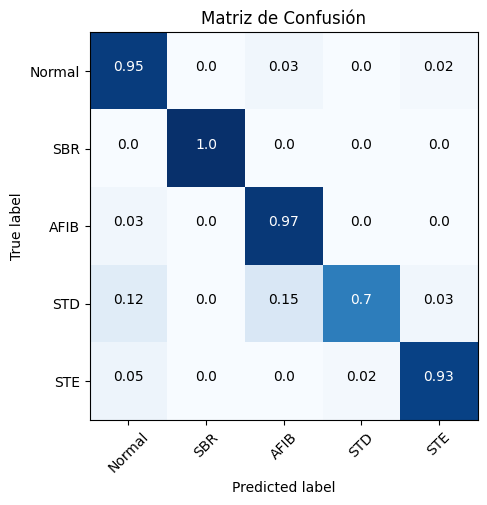

In [13]:

# cargar datos de prueba
data_test, labels_test = load_data_test_cnn()

# Imprimiendo tamaño de test
print()

# cargar modelo previamente entrenado
model_file = 'C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModelosCheckpointsOptuna\\NS\\mejor_modelo_trial'
modelo='39'
Best_Model_CNN = keras.models.load_model(model_file+modelo+'.h5',custom_objects={'f1': f1})
# hacer la predicción
y_prediction = Best_Model_CNN.predict(data_test)
print(y_prediction)
rounded_predictions=np.argmax(y_prediction,axis=1)

# obtener matriz de confusión y graficarla
cm = confusion_matrix(y_true=labels_test, y_pred=rounded_predictions)
cm_plot_labels = ['Normal','SBR','AFIB','STD','STE']
ruta='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\MatricesDeConfusion\\NS\\'
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, ruta=ruta+'MatrizMejorModeloOptuna_NS.png',title='Matriz de Confusión',normalize=True)

# Entrenando modelo con los mejores Hiperparámetros

In [14]:
def create_model_cnn():
    input_shape = (4000, 51, 241, 2)
    ModelCNN2D=keras.models.Sequential()
    ModelCNN2D.add(keras.layers.Conv2D(32,(3,3),padding="same",activation="relu",input_shape=input_shape[1:]))
    ModelCNN2D.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    ModelCNN2D.add(keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"))
    ModelCNN2D.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    ModelCNN2D.add(keras.layers.Flatten())
    ModelCNN2D.add(keras.layers.Dense(256,activation="relu",activity_regularizer=regularizers.L1L2(1e-3)))
    ModelCNN2D.add(keras.layers.Dropout(0.6))
    ModelCNN2D.add(keras.layers.Dense(5,activation="softmax"))
    ModelCNN2D.summary()
    return ModelCNN2D


In [21]:
K.clear_session()
reset_keras()
data_test, labels_test_OHE,data_val, labels_val_OHE = load_data_cnn()
# Entrenando y guardando el modelo
Best_Hiper_ModelCNN=create_model_cnn()
opt = optimizers.Adam(learning_rate=0.008557766173243489)
Best_Hiper_ModelCNN.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy',tf.keras.metrics.AUC(),f1])
ruta_modelo='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModelosCheckpointsMejoresHiperparametros\\NS\\'
ruta_modelo_trial=ruta_modelo+'mejor_modelo_CNN_NS.h5'
Checkpoint = ModelCheckpoint(ruta_modelo_trial, monitor="val_accuracy", save_best_only=True, mode="max")
history=Best_Hiper_ModelCNN.fit(data_test,labels_test_OHE,verbose=1,epochs=50,batch_size=182,validation_data=(data_val,labels_val_OHE),callbacks=[Checkpoint])

41047
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 51, 241, 2)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 241, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 120, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 120, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 60, 64)       0         
 2D)                                                             
                                                                 
 f

# Graficas modelo con los mejores hiperparámetros

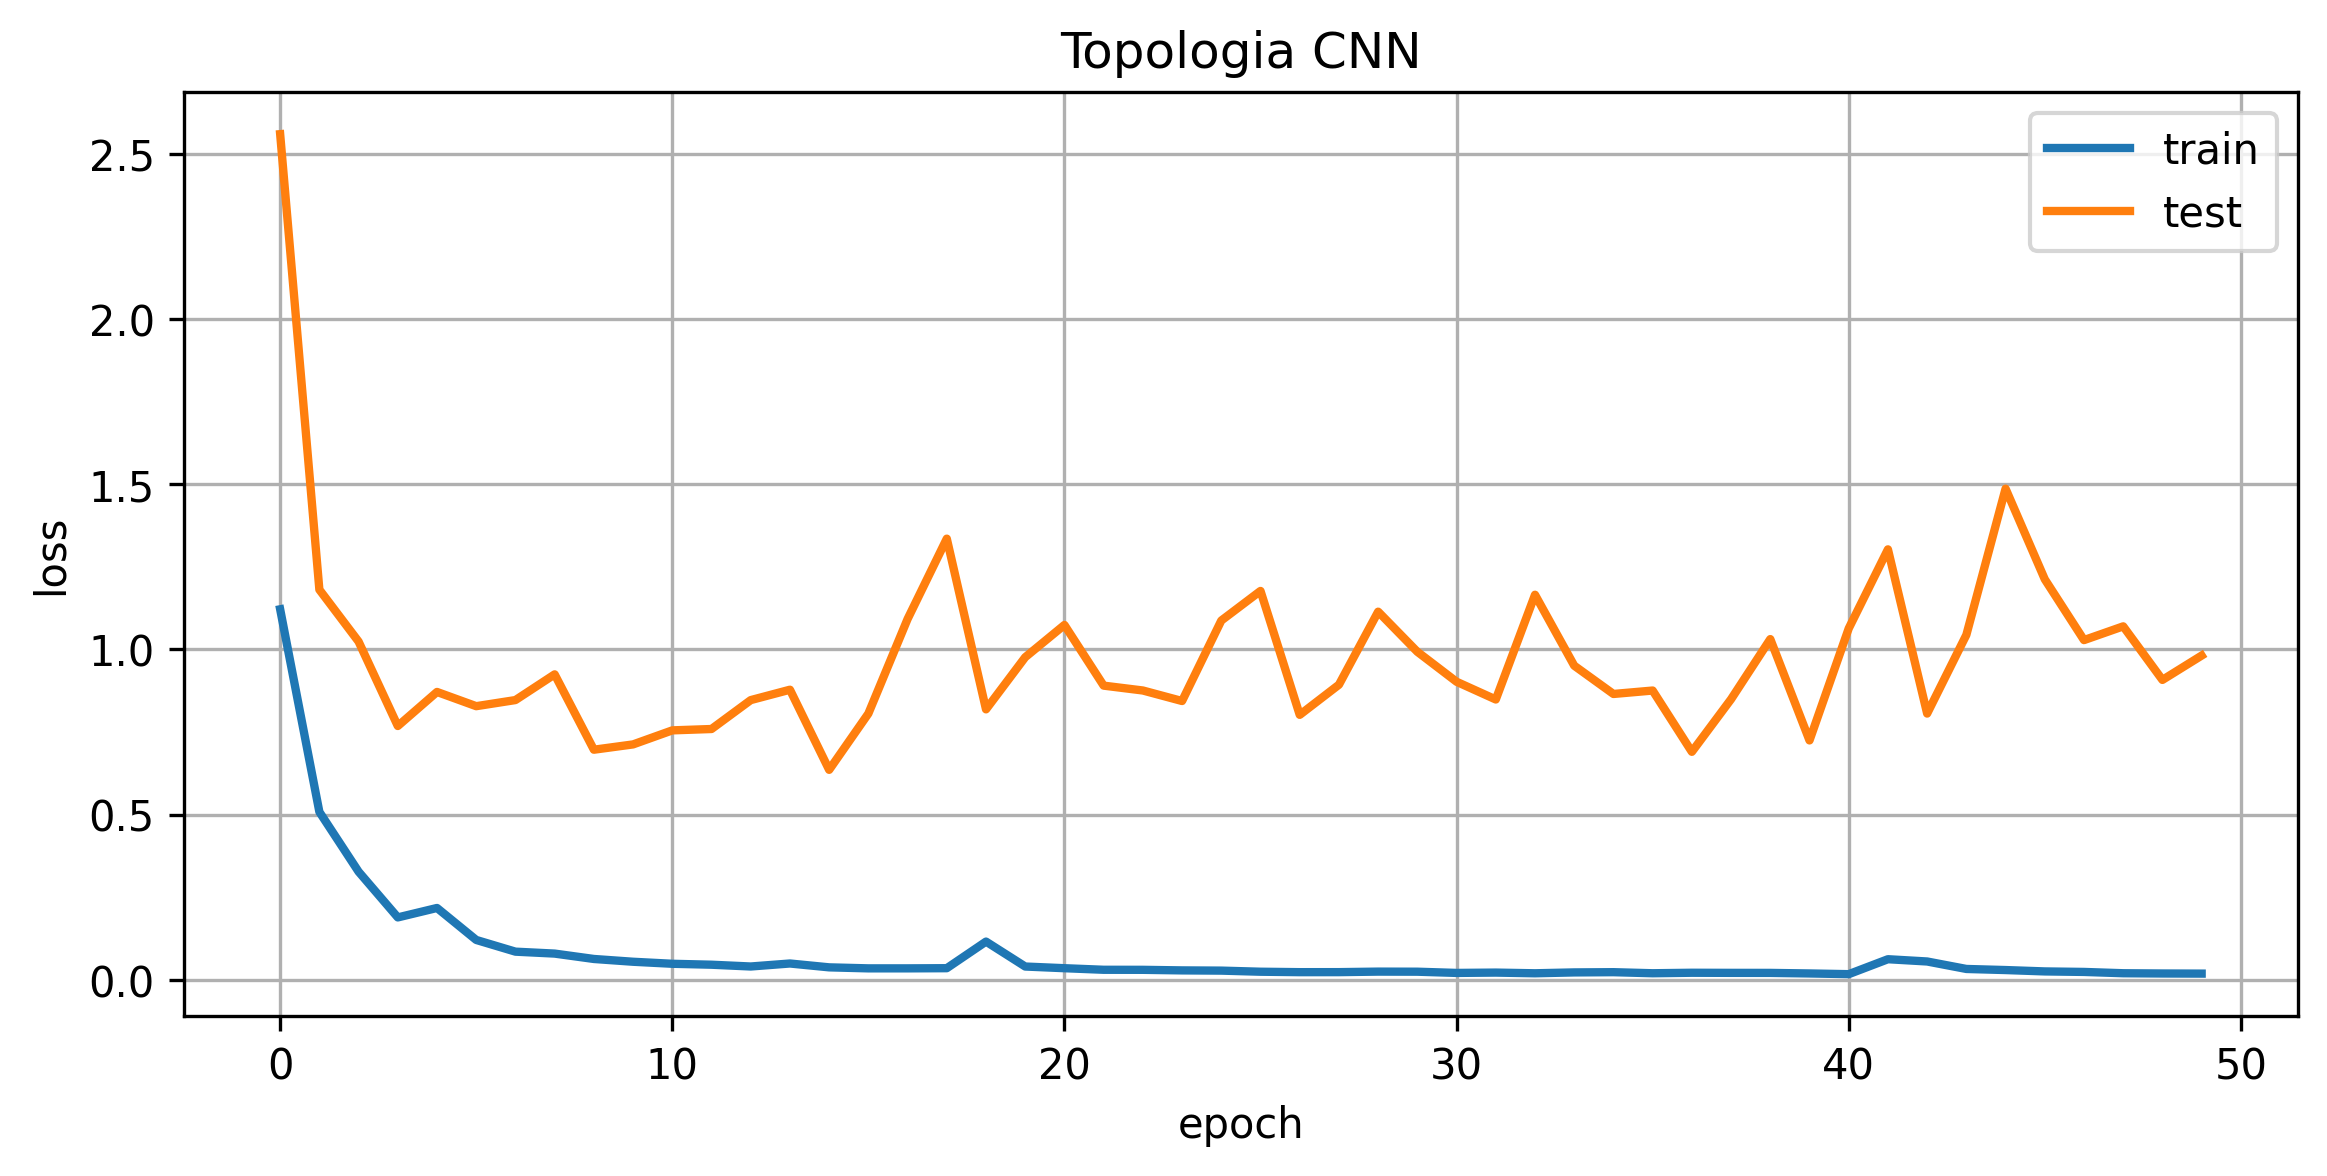

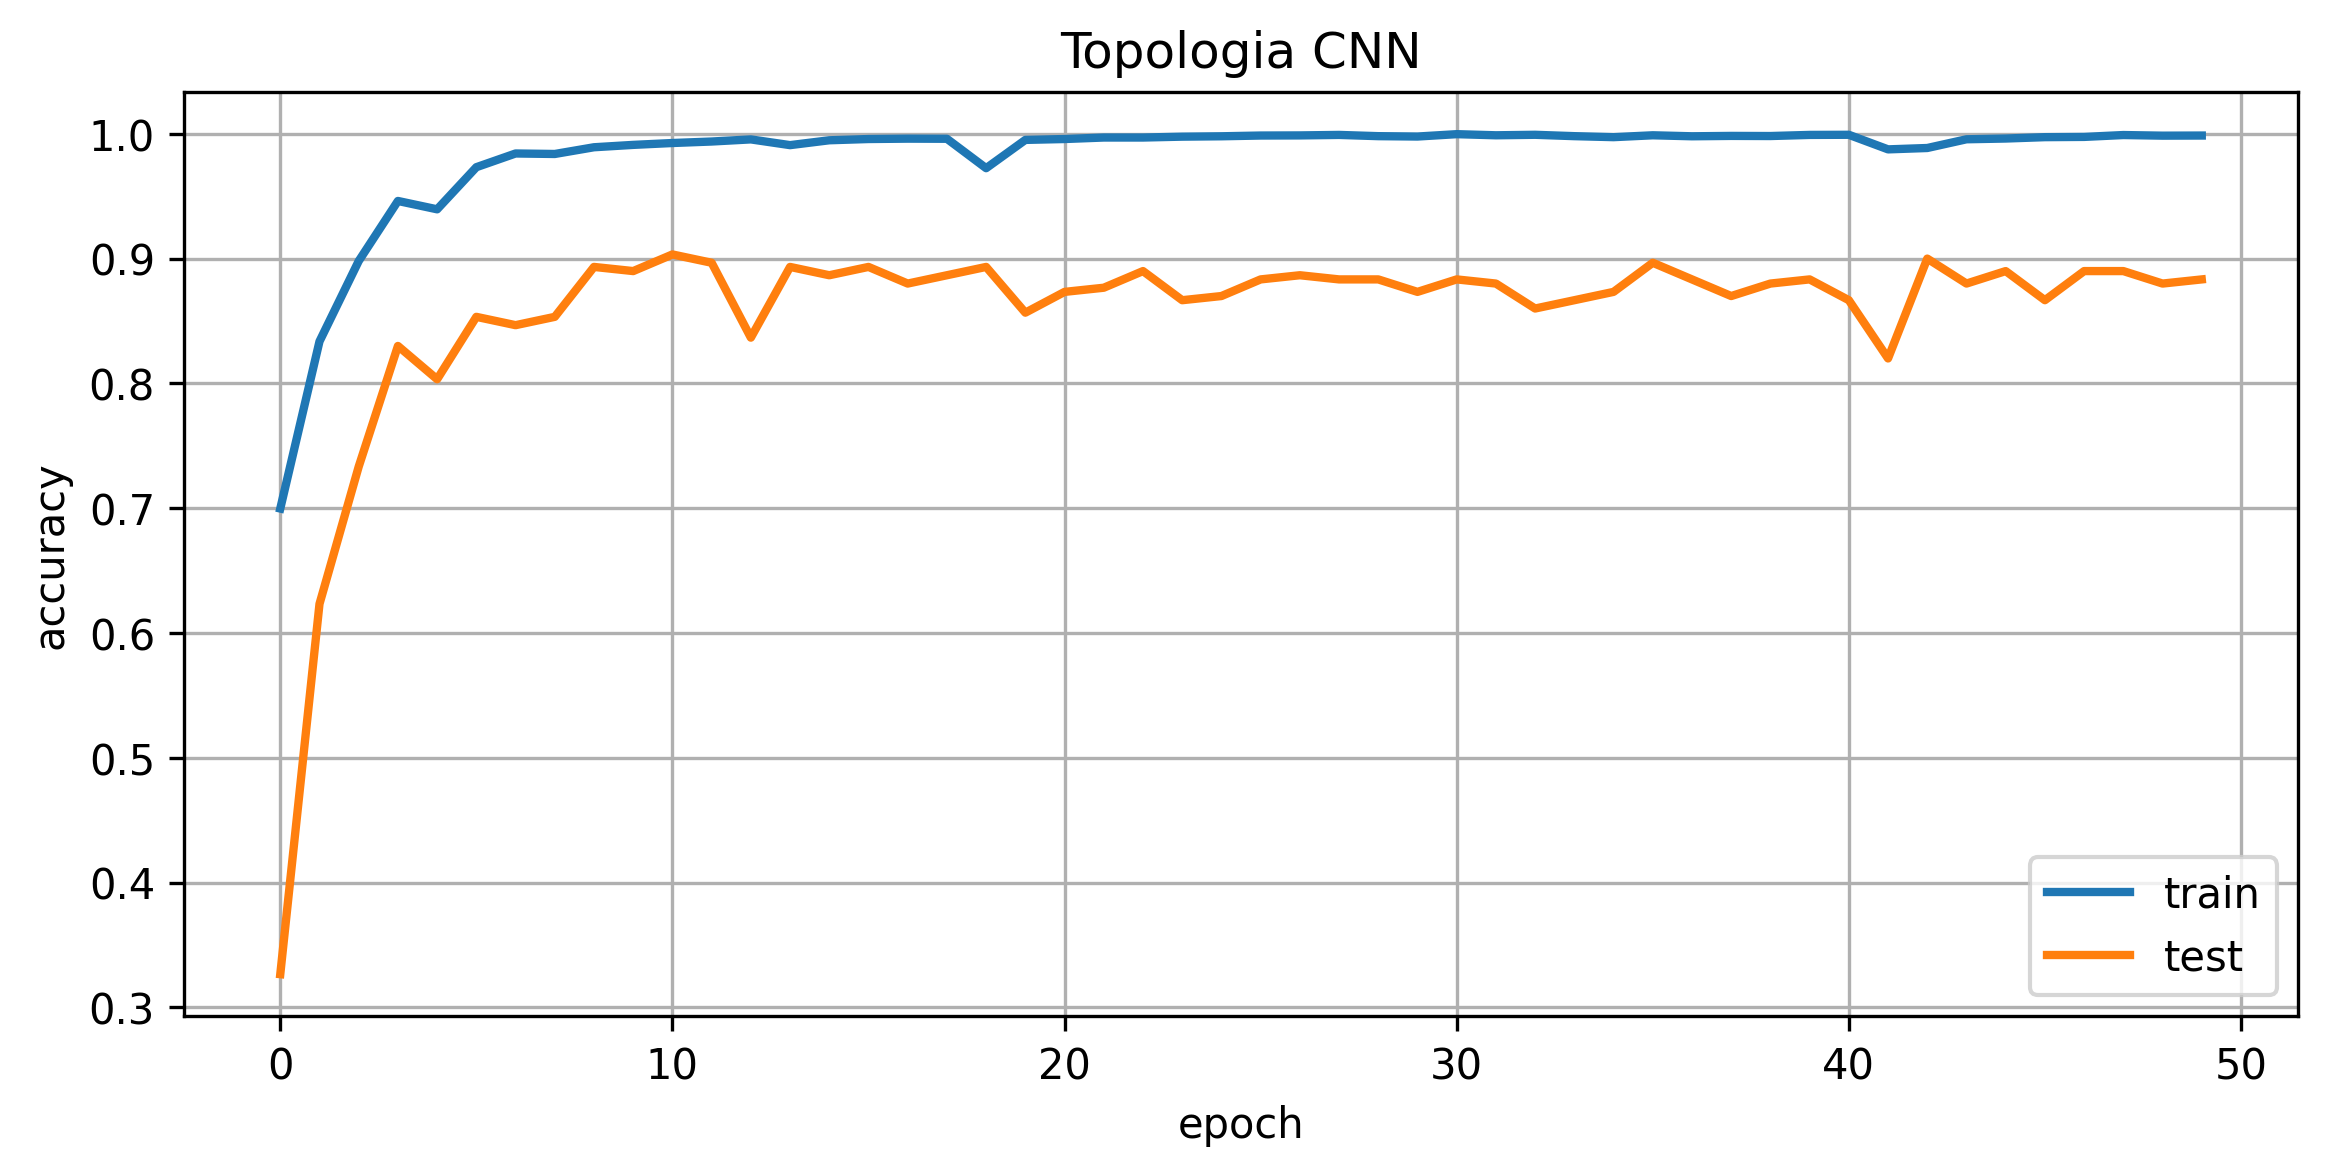

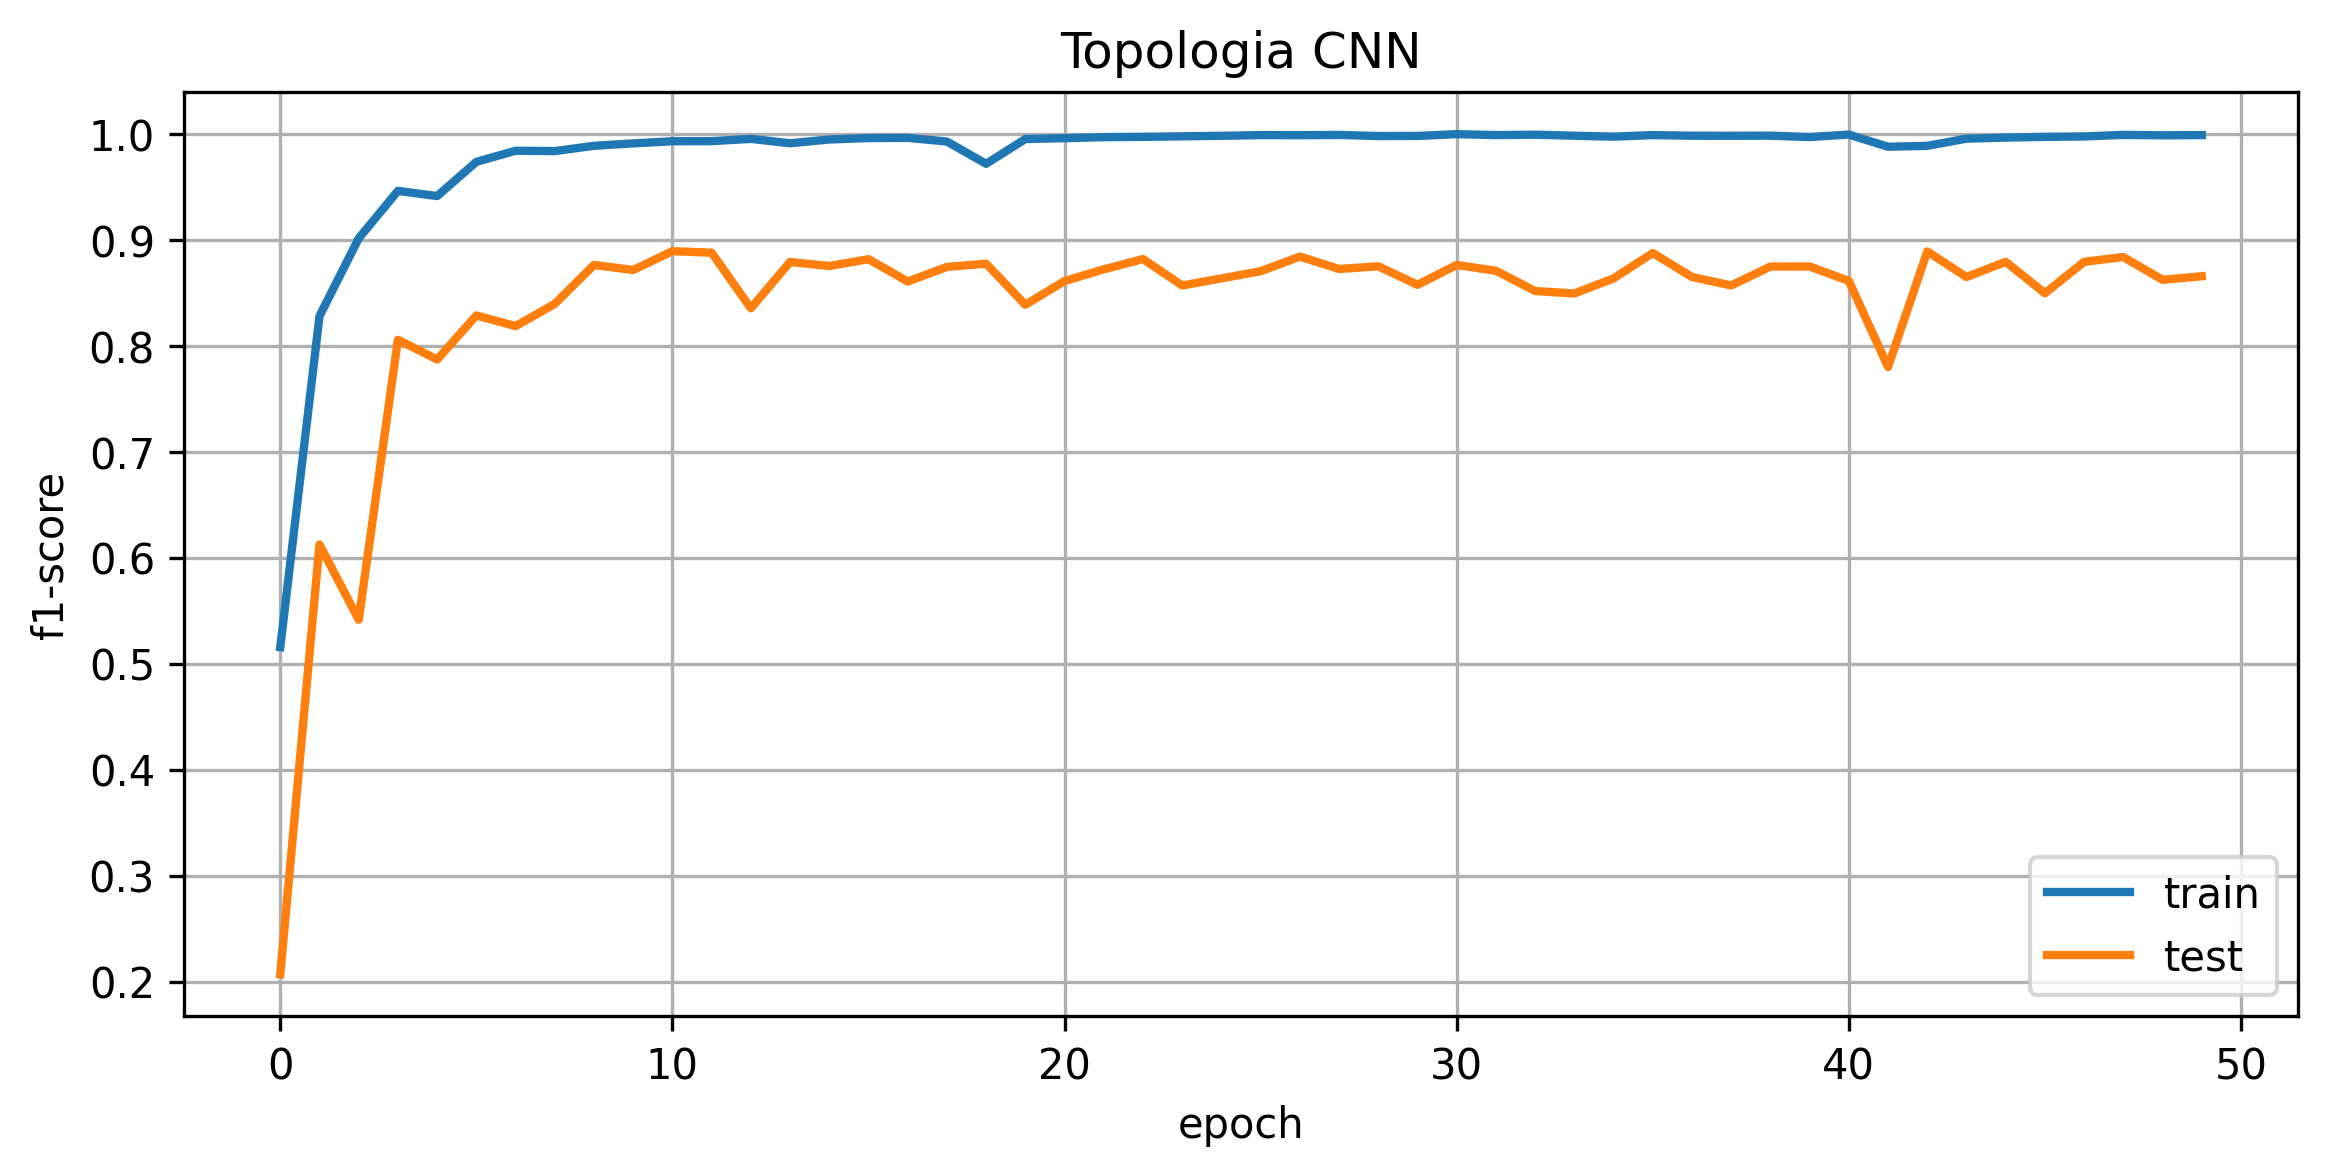

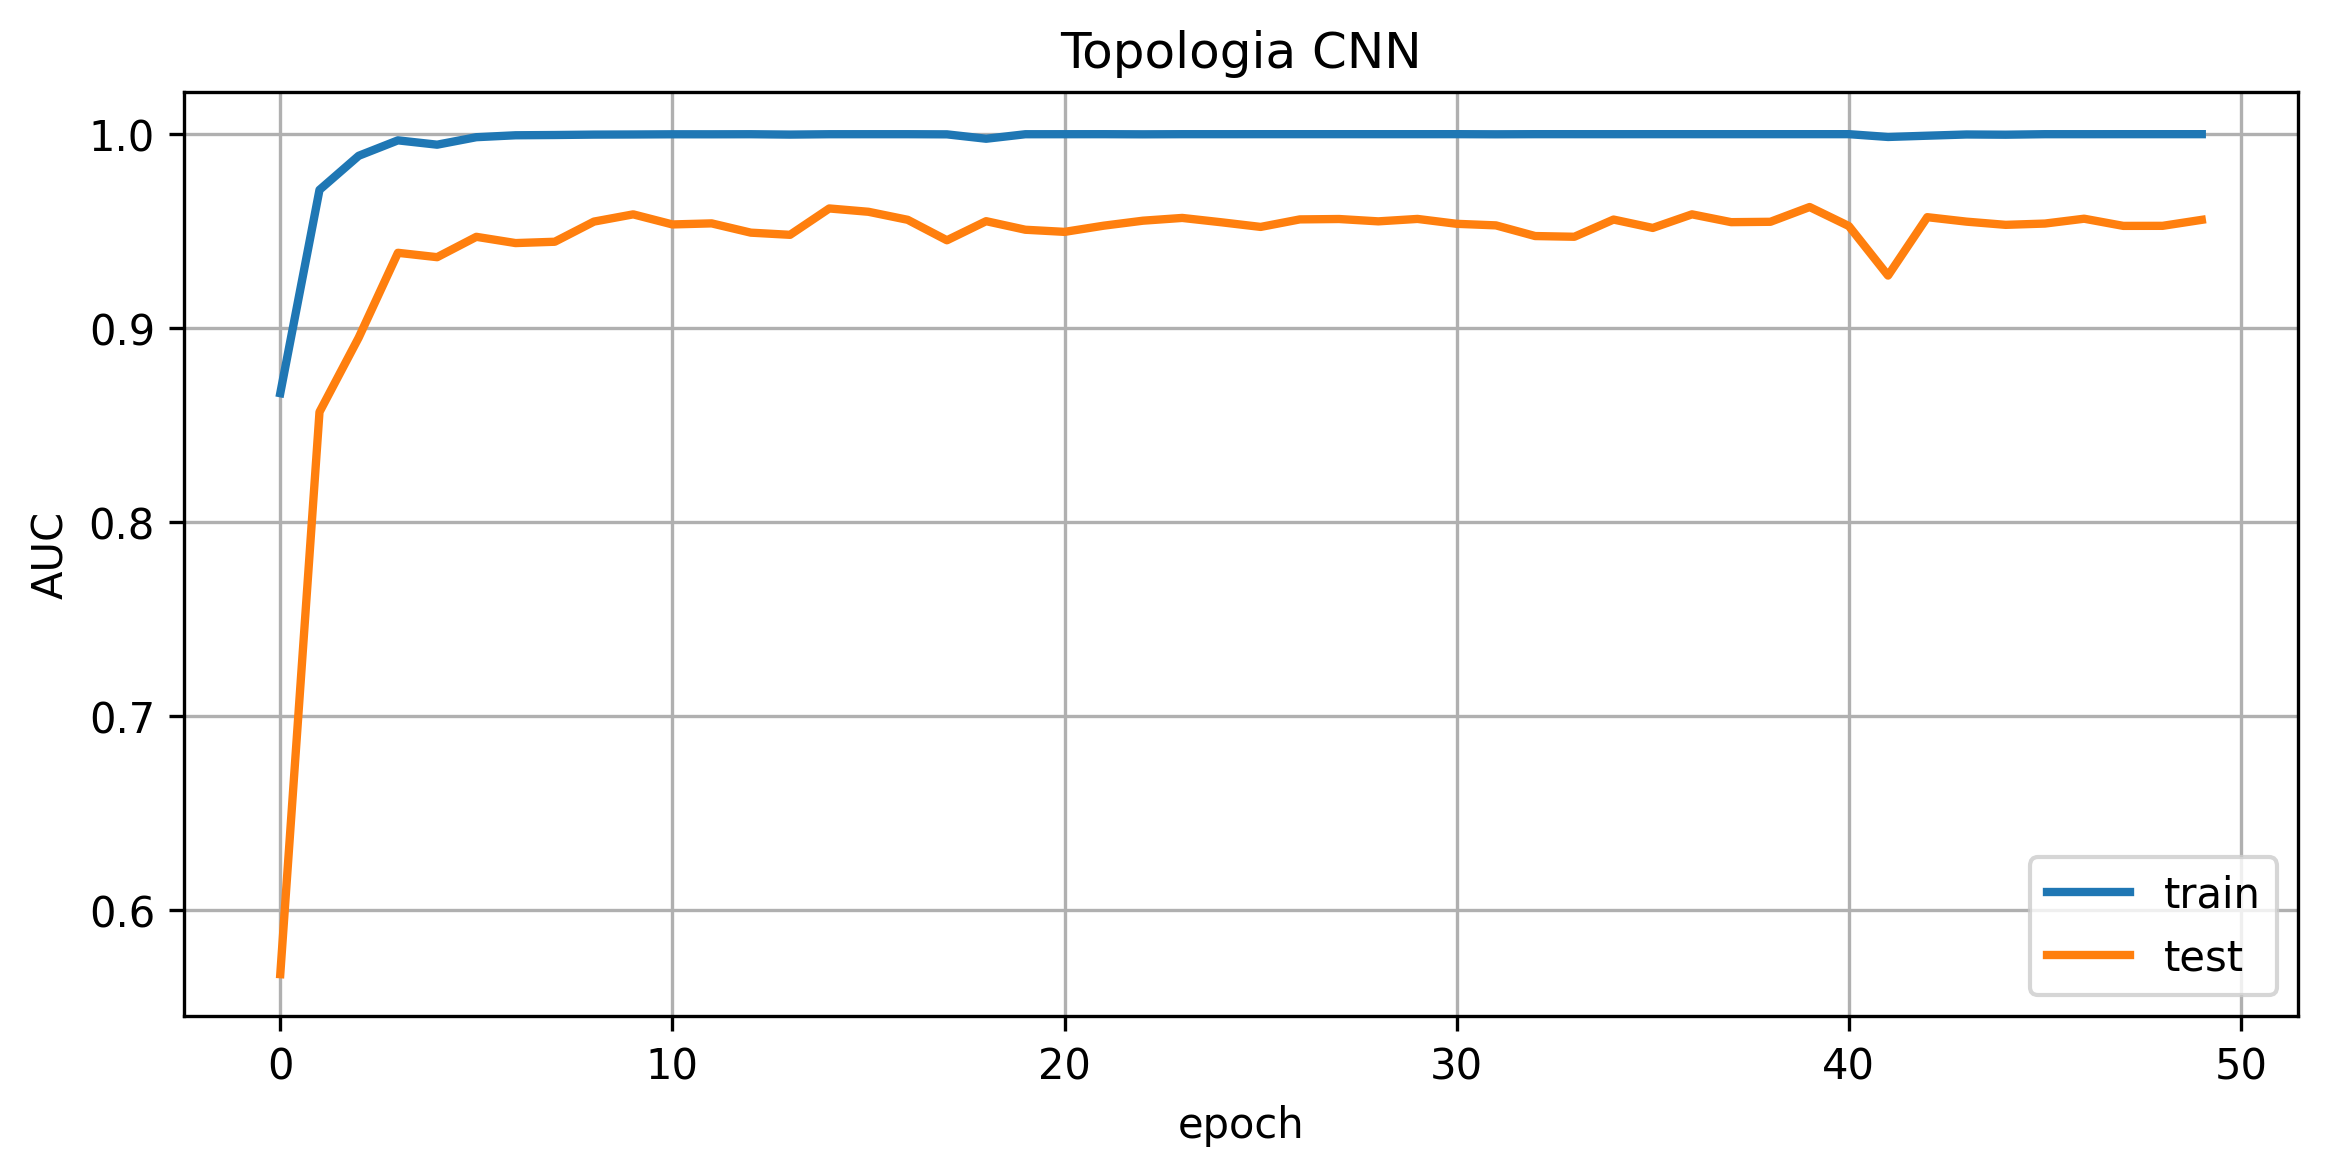

In [22]:
plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,1)
plt.plot(history.history['loss'], linewidth=2, )
plt.plot(history.history['val_loss'], linewidth=2)
plt.title('Topologia CNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], linewidth=2,)
plt.plot(history.history['val_accuracy'], linewidth=2,)
plt.title('Topologia CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,2)
plt.plot(history.history['f1'], linewidth=2,)
plt.plot(history.history['val_f1'], linewidth=2,)
plt.title('Topologia CNN')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,2)
plt.plot(history.history['auc'], linewidth=2,)
plt.plot(history.history['val_auc'], linewidth=2,)
plt.title('Topologia CNN')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()


Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
10/10 [==============================] - 0s 9ms/step
[[9.9934298e-01 1.2218916e-04 3.1763504e-04 9.1571063e-05 1.2556222e-04]
 [9.9315464e-01 1.5962496e-03 2.9567142e-03 9.6098456e-04 1.3313667e-03]
 [9.9273080e-01 2.2463538e-03 3.5652725e-03 7.0800557e-04 7.4961939e-04]
 ...
 [1.2783770e-13 2.7199545e-13 3.3210770e-18 2.2851480e-16 1.0000000e+00]
 [3.6425302e-08 6.2555259e-08 1.2797546e-10 9.5722132e-09 9.9999988e-01]
 [1.4669307e-04 1.1292494e-07 1.2730823e-06 5.3817946e-03 9.9447012e-01]]
Normalized confusion matrix
[[0.85 0.03 0.02 0.07 0.03]
 [0.   1.   0.   0.   0.  ]
 [0.05 0.   0.95 0.   0.  ]
 [0.02 0.   0.02 0.45 0.52]
 [0.   0.   0.   0.   1.  ]]


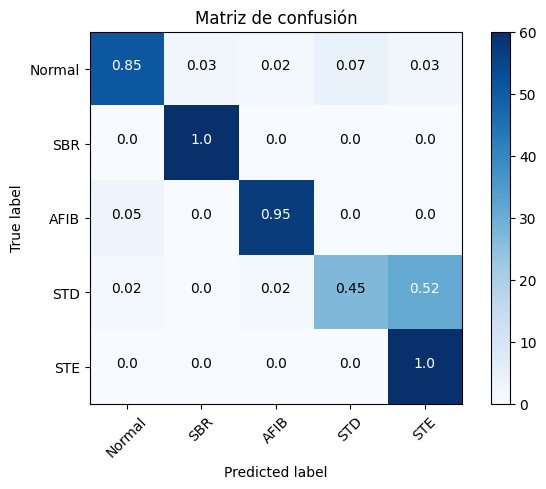

In [24]:
data_test, labels_test = load_data_test_cnn()
y_prediction = Best_Hiper_ModelCNN.predict(data_test)
print(y_prediction)
rounded_predictions=np.argmax(y_prediction,axis=1)
cm = confusion_matrix(y_true=labels_test, y_pred=rounded_predictions)
cm_plot_labels = ['Normal','SBR','AFIB','STD','STE']
ruta='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\MatricesDeConfusion\\NS\\MatrizDatosTestModeloEntrenadoNS.png'
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,ruta=ruta, title='Matriz de confusión',normalize=True)

# Mejor modelo entrenado del modelo de hiperparámetros

Tamaño datos test: (300, 51, 241, 2)
Tamaño etiquetas de test: (300,)
10/10 [==============================] - 0s 18ms/step
[[9.9991536e-01 4.0785626e-06 1.2687316e-05 1.0422745e-05 5.7415320e-05]
 [1.0000000e+00 2.9988407e-09 1.0076699e-08 9.3122043e-10 1.6096430e-09]
 [9.9961829e-01 8.5209795e-05 1.8869822e-04 4.7278911e-05 6.0575807e-05]
 ...
 [1.3198883e-04 5.3486169e-06 2.1488629e-09 2.6502330e-06 9.9986005e-01]
 [8.5530937e-06 4.5671578e-09 1.9039470e-09 9.1141250e-05 9.9990034e-01]
 [3.4262268e-06 4.9626035e-08 2.8456864e-09 9.7379107e-06 9.9998677e-01]]
Normalized confusion matrix
[[0.9  0.03 0.03 0.   0.03]
 [0.   1.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.  ]
 [0.02 0.   0.02 0.45 0.52]
 [0.   0.   0.   0.   1.  ]]


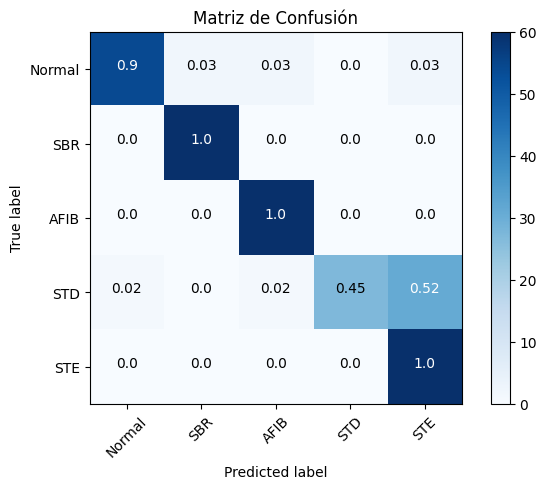

In [26]:
# cargar datos de prueba
data_test, labels_test = load_data_test_cnn()
# data_test=np.moveaxis(data_test,1,-2)

# cargar modelo previamente entrenado
model_file = 'C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModelosCheckpointsMejoresHiperparametros\\NS\\'
ModelCNN_best = keras.models.load_model(model_file+'mejor_modelo_CNN_NS.h5',custom_objects={"f1": f1})
# hacer la predicción
y_prediction = ModelCNN_best.predict(data_test)
print(y_prediction)
rounded_predictions=np.argmax(y_prediction,axis=1)

# obtener matriz de confusión y graficarla
cm = confusion_matrix(y_true=labels_test, y_pred=rounded_predictions)
cm_plot_labels = ['Normal','SBR','AFIB','STD','STE']
ruta='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\MatricesDeConfusion\\NS\\\MatrizDatosTestMejorModeloEntrenadoNS.png'
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,ruta=ruta,title='Matriz de Confusión',normalize=True)

# Guardando datos del modelo entrenado

In [58]:
import json
#Guardando historiales
path='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModeloMejoresHiperparametros\\NS\\'
with open(path+'historial_Modelo_CNN_NS_final.json', 'w') as f:
    json.dump(history.history, f)

#Guardando mejor modelo
Best_Hiper_ModelCNN.save('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModeloMejoresHiperparametros\\NS\\Modelo_CNN_NS_final.h5')
ModelCNN_best.save('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModeloMejoresHiperparametros\\NS\\Modelo_CNN_NS_Best_final.h5')

In [1]:
import json
ruta_json='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\ModelosCheckpointsOptuna\\NS\\historial_Modelo_CNN_trial'
archivoAcargar='40.json'
with open(ruta_json+archivoAcargar, 'r') as archivo_json:
    datos = json.load(archivo_json)

print(datos)

{'loss': [0.8691124320030212, 0.2340279370546341, 0.12490077316761017, 0.09277790784835815, 0.08282534033060074, 0.05677851662039757, 0.048697251826524734, 0.05474292114377022, 0.052298083901405334, 0.03589984402060509, 0.03538772463798523, 0.03025347925722599, 0.029587799683213234, 0.030708538368344307, 0.025190994143486023, 0.024723611772060394, 0.023851048201322556, 0.025229521095752716, 0.034924447536468506, 0.09101352840662003, 0.04332771524786949, 0.03265010192990303, 0.02659243904054165, 0.023251987993717194, 0.02127445861697197, 0.019869426265358925], 'accuracy': [0.7780329585075378, 0.9425861239433289, 0.9748377203941345, 0.9841238260269165, 0.9851223230361938, 0.9925112128257751, 0.9957064390182495, 0.9934098720550537, 0.9930104613304138, 0.997803270816803, 0.9968047738075256, 0.9991013407707214, 0.9982026815414429, 0.998502254486084, 0.9992011785507202, 0.9994009137153625, 0.9988017678260803, 0.9986020922660828, 0.9951073527336121, 0.9793310165405273, 0.9931103587150574, 0.9

In [2]:
import numpy as np
index_max=np.argmax(datos['val_accuracy'])
print('val_accuracy:',datos['val_accuracy'][index_max]*100)

index_max=np.argmax(datos['accuracy'])
print('accuracy:',datos['accuracy'][index_max]*100)

index_max=np.argmax(datos['val_f1'])
print('val_f1:',datos['val_f1'][index_max]*100)

index_max=np.argmax(datos['f1'])
print('f1:',datos['f1'][index_max]*100)

index_max=np.argmax(datos['val_auc'])
print('val_auc:',datos['val_auc'][index_max]*100)

index_max=np.argmax(datos['auc'])
print('auc:',datos['auc'][index_max]*100)

val_accuracy: 93.99999976158142
accuracy: 99.94009137153625
val_f1: 92.62403845787048
f1: 99.93615746498108
val_auc: 98.8926351070404
auc: 99.99997615814209


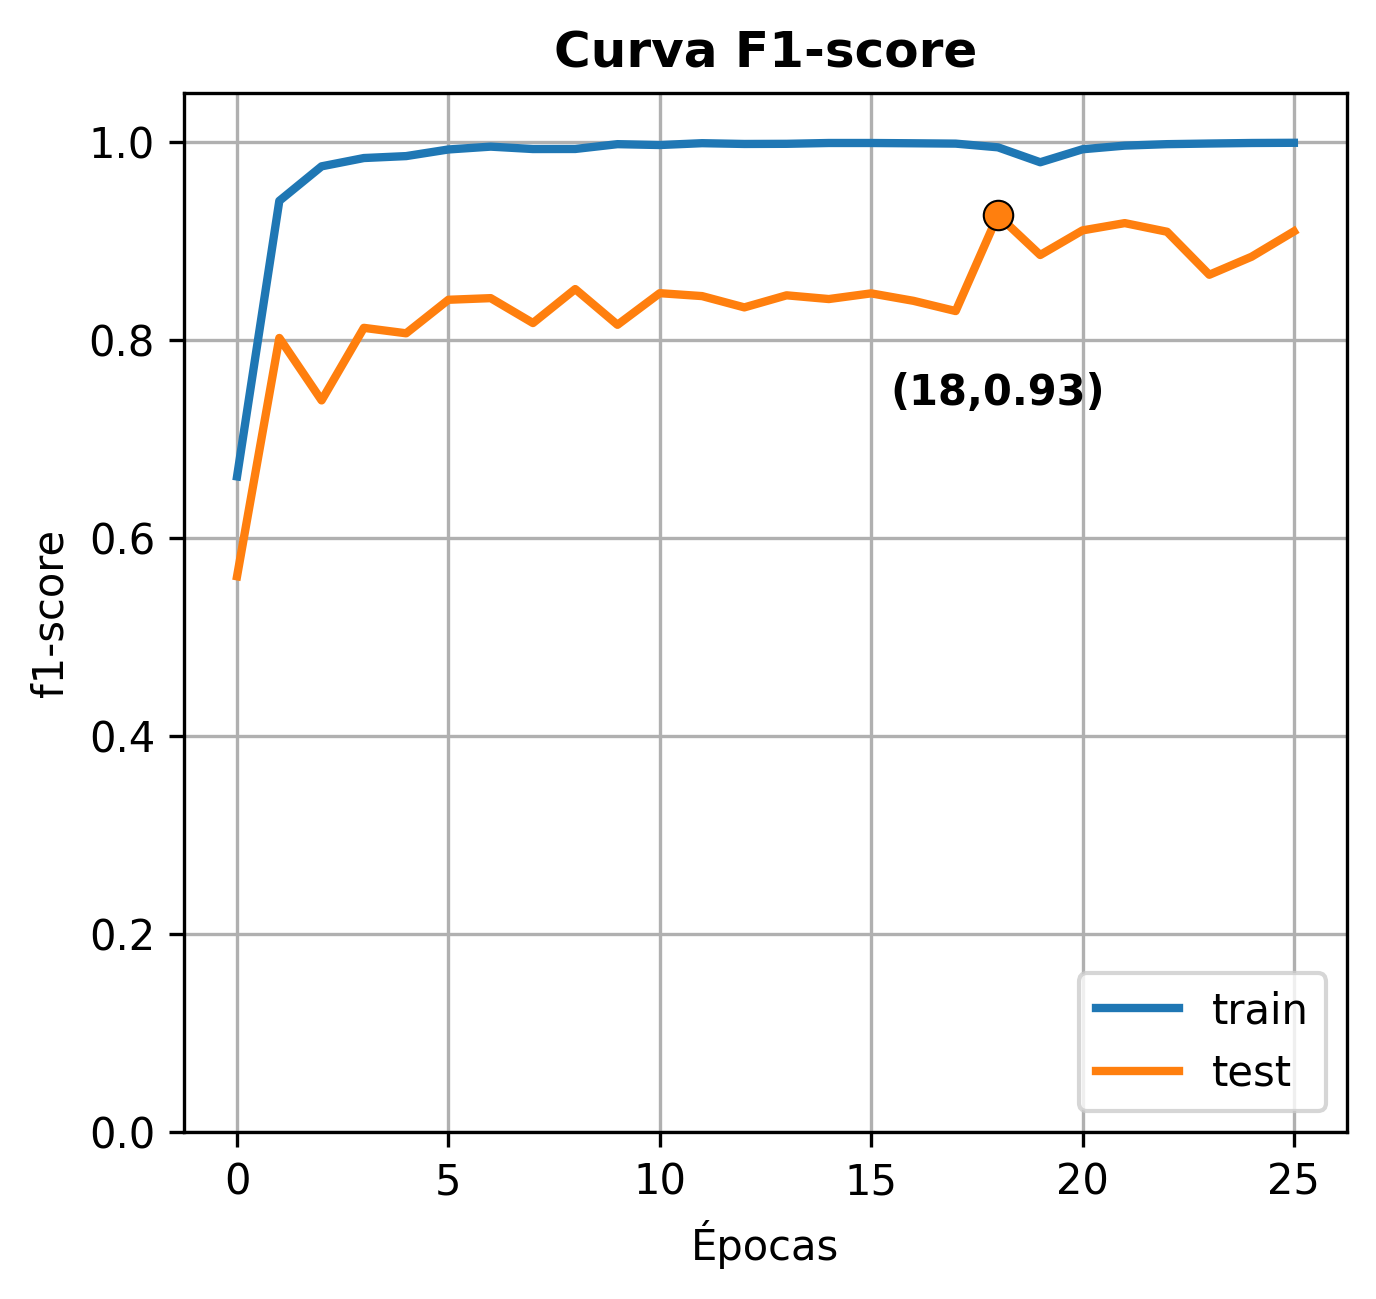

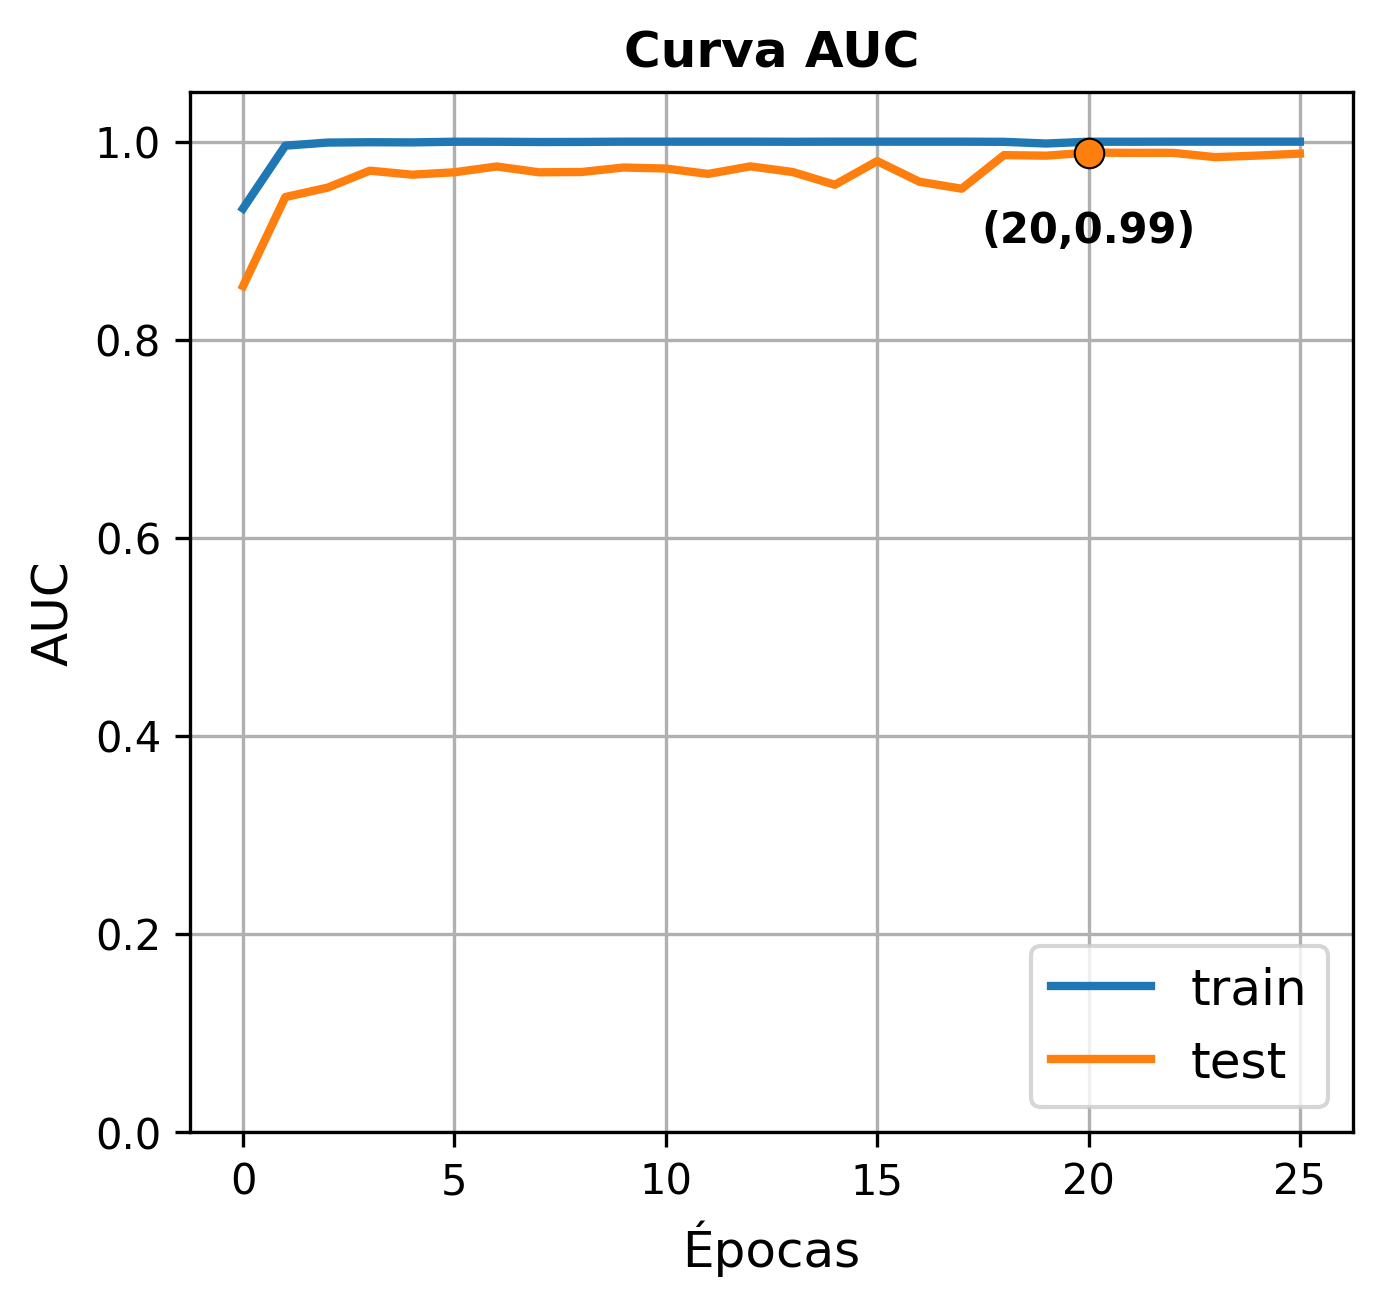

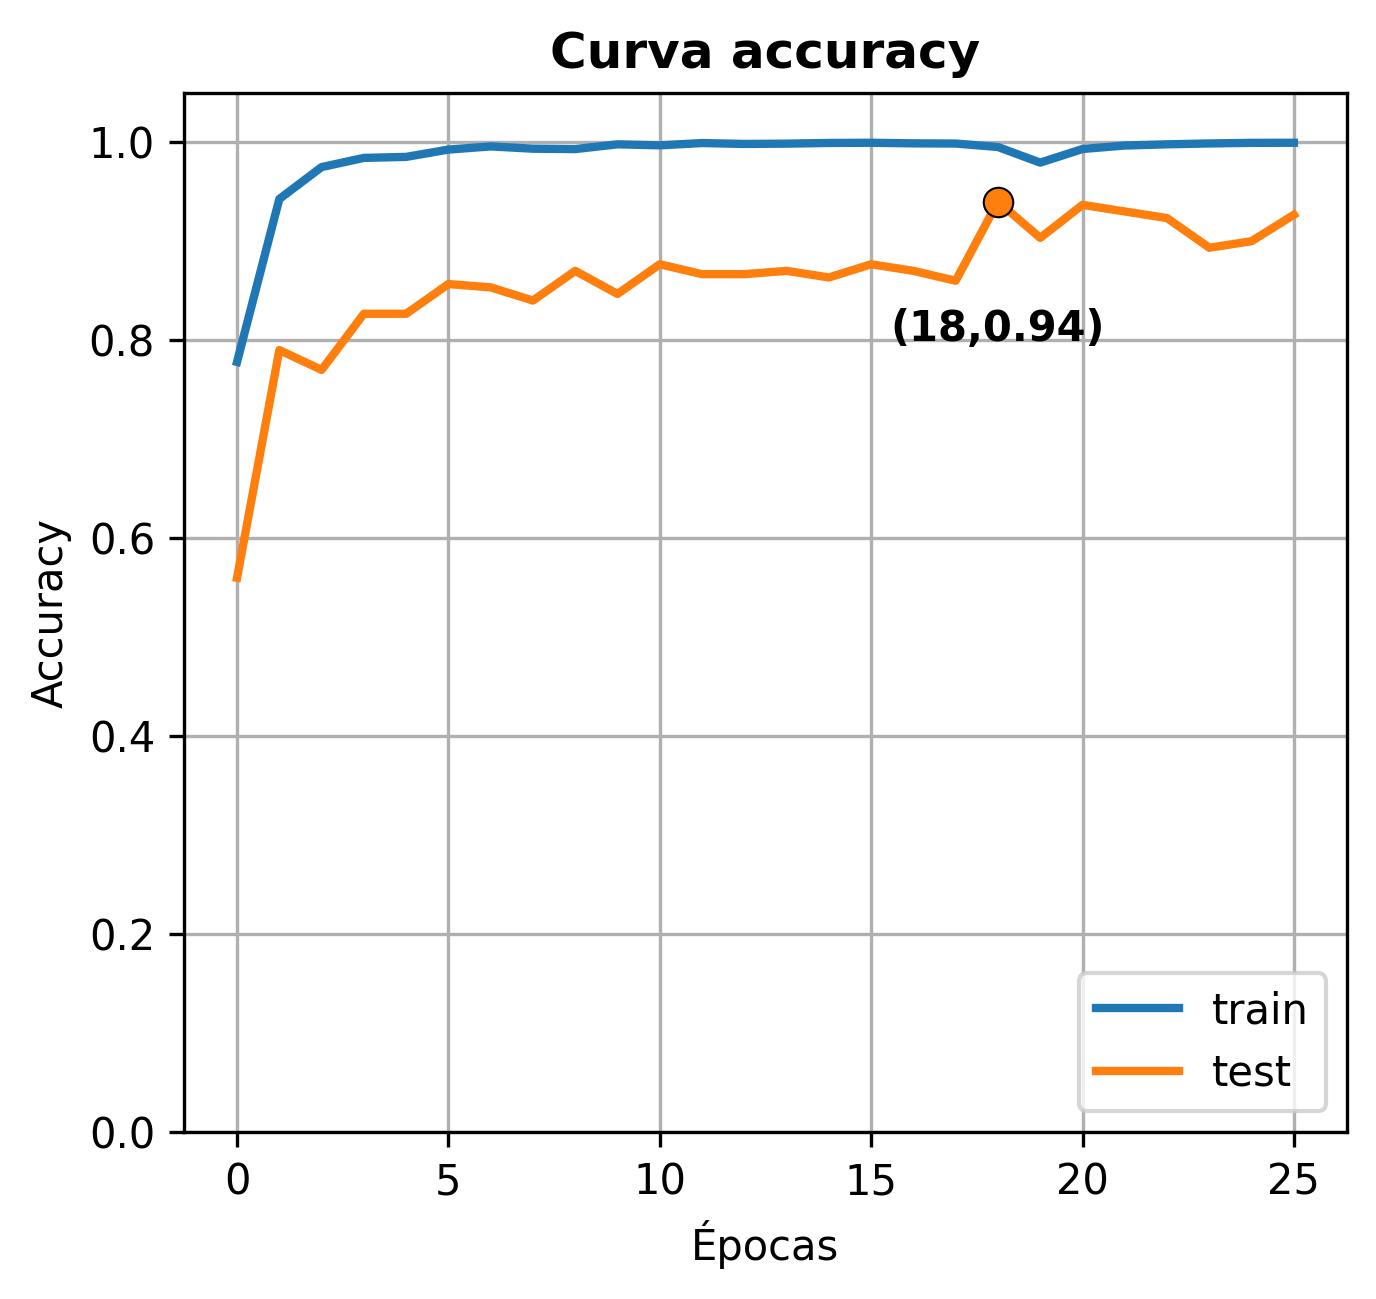

In [3]:
# Crear una nueva figura con solo la subfigura 3
fig2, ax2 = plt.subplots(figsize=(5,4.5), dpi=300)
ax2.plot(datos['f1'], linewidth=2,)
ax2.plot(datos['val_f1'], linewidth=2,color='#FF7F0E')
ax2.set_ylabel('f1-score')
ax2.set_xlabel('Épocas')
ax2.legend(['train', 'test'],loc='lower right')
ax2.grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_f1'])
y_max = datos['val_f1'][index_max]
t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
ax2.scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
ax2.text(t_max, y_max-0.2, f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold')

# Establecer el rango máximo en el eje Y
y_max = 1.05
ax2.set_ylim([0, y_max])

plt.title('Curva F1-score',fontweight='bold')

# Guardar la figura en un archivo separado
plt.savefig('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\Imagenes\\NS\\subfigura2.png', dpi=300)

# Mostrar la figura
plt.show()



# Crear una nueva figura con solo la subfigura 3
fig2, ax2 = plt.subplots(figsize=(5,4.5), dpi=300)
ax2.plot(datos['auc'], linewidth=2,)
ax2.plot(datos['val_auc'], linewidth=2,color='#FF7F0E')
ax2.set_ylabel('AUC',fontsize=12)
ax2.set_xlabel('Épocas',fontsize=12)
ax2.legend(['train', 'test'],loc='lower right',fontsize=12)
ax2.grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_auc'])
y_max = datos['val_auc'][index_max]
t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
ax2.scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
ax2.text(t_max, y_max-0.1, f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold')

# Establecer el rango máximo en el eje Y
y_max = 1.05
ax2.set_ylim([0, y_max])

plt.title('Curva AUC',fontweight='bold')

# Guardar la figura en un archivo separado
plt.savefig('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\Imagenes\\NS\\subfigura3.png', dpi=300)

# Mostrar la figura
plt.show()

# Crear una nueva figura con solo la subfigura 3
fig2, ax2 = plt.subplots(figsize=(5,4.5), dpi=300)
ax2.plot(datos['accuracy'], linewidth=2,)
ax2.plot(datos['val_accuracy'], linewidth=2,color='#FF7F0E')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Épocas')
ax2.legend(['train', 'test'],loc='lower right')
ax2.grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_accuracy'])
y_max = datos['val_accuracy'][index_max]
t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
ax2.scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
ax2.text(t_max, y_max-0.15, f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold')

# Establecer el rango máximo en el eje Y
y_max = 1.05
ax2.set_ylim([0, y_max])

plt.title('Curva accuracy',fontweight='bold')

# Guardar la figura en un archivo separado
plt.savefig('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaConvolucional\\Imagenes\\NS\\subfigura1.png', dpi=300)

# Mostrar la figura
plt.show()